In [1]:
# import sys
# sys.path.append('..')
# # sys.path.append('../functions')
import os
import time

import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pydicom
os.environ['CUDA_VISIBLE_DEVICES']="None"
HOME = os.path.dirname(os.path.abspath(os.curdir))

%matplotlib inline

UsageError: unrecognized arguments: # has to be rerun for real time plotting (nonsense, i know)


## saving npy files

In [ ]:
arr = [1,3,4,5]

In [ ]:
np.save('data/test.npy', np.array(arr).astype(np.float32))

In [ ]:
arr_l = np.load('data/test.npy')

In [ ]:
arr_l

In [ ]:
os.path.exists('data')

In [ ]:
fnames = np.load('data/npy_data/train_fnames.npy')

In [ ]:
fnames.shape

## tesing train test split bug

In [ ]:
df = pd.read_csv("data/stage_1_train_labels.csv")
class_df = pd.read_csv('data/stage_1_detailed_class_info.csv')
# df = df[df["Target"] == 0]
# df.reset_index(drop=True, inplace=True)
# df_groups = df.groupby(["patientId"]).groups
# fnames = list(df_groups.keys())


In [ ]:
class_df.head(10)

In [ ]:
df.head()

In [ ]:
# df['class'] = df.apply(lambda x: class_df[class_df['patientId'] == x]['class'])
df['class'] = class_df['class']

In [ ]:
df.head(10)

In [ ]:
image_df = df.groupby('patientId').apply(lambda x: x.sample(1))

In [ ]:
image_df.head(10)

In [ ]:
image_df.sample?

In [ ]:
image_df.shape

In [ ]:
raw_train_df, valid_df = train_test_split(image_df, test_size=0.1, random_state=2018, stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

In [ ]:
raw_train_df.head()

In [ ]:
raw_train_df['class'].value_counts()

In [ ]:
valid_df['class'].value_counts()

In [ ]:
tf = list(raw_train_df.patientId)
vf = list(valid_df.patientId)

In [ ]:
len(tf), len(vf)

In [ ]:
tf[:4]

In [ ]:
'''Check if tf and vf are mutually exclusive'''
print(len(tf + vf) == image_df.shape[0])
len(set(tf + vf)) == len(tf) + len(vf)

In [ ]:
len(tf), len(vf)

##### sanity check

In [ ]:
train_fnames = np.load('data/npy_data/train_fnames.npy')
val_fnames = np.load('data/npy_data/val_fnames.npy')

In [ ]:
len(train_fnames), len(val_fnames), (len(set(list(train_fnames) + list(val_fnames))) == len(train_fnames) + len(val_fnames))

In [ ]:
tl = np.load('data/npy_data/train_labels.npy')
vl = np.load('data/npy_data/val_labels.npy')

In [ ]:
np.unique(tl, return_counts=True)

In [ ]:
np.unique(vl, return_counts=True)

## class analysis of the boxes

In [ ]:
class_df = pd.read_csv('data/stage_1_detailed_class_info.csv')

In [ ]:
class_df.head()

In [ ]:
class_df.groupby('class').groups

In [ ]:
class_df.head(10)()

In [ ]:
train_df = pd.read_csv('data/stage_1_train_labels.csv')
train_df.head(10)

In [ ]:
train_df.shape, class_df.shape

In [ ]:
grp = class_df.groupby(["patientId"]).groups

In [ ]:
class_df.iloc[12790]['class']

In [ ]:
class_df['class'].nunique()

In [ ]:
class_df.groupby(["class"]).nunique()

## Analysing ground truth bboxes

In [16]:
DATA_ROOT = os.path.join(HOME, "data")
print('Reading, gouping, spliting data...')
df = pd.read_csv(os.path.join(DATA_ROOT, "stage_1_train_labels.csv"))
df_groupby = df.groupby("patientId")
df_groups = df_groupby.groups
image_df = df_groupby.apply(lambda x: x.sample(1))
fnames = image_df.patientId

Reading, gouping, spliting data...


In [17]:
labels, boxes = [], []
widths, heights = [], []
for name in tqdm(fnames):
    indices = df_groups[name]
    box, label = [], []
    for idx in indices:
        line = df.iloc[idx]
        if line["Target"]:
            x, y, w, h = line["x"], line["y"], line["width"], line["height"]
            boxes.append([x, y, (x + w), (y + h)])
            widths.append(w)
            heights.append(h)
boxes = np.array(boxes) * 300/1024
widths = np.array(widths) * 300/1024
heights = np.array(heights) * 300/1024

#Note: GT boxes are in scale of 1024, need to be converted to 300 scale and are of format x,y,x,y (NOT THE CASE WITH PRIOR BOXES)

100%|██████████| 25684/25684 [00:15<00:00, 1647.10it/s]


In [18]:
min(widths), max(widths), min(heights), max(heights)

(11.71875, 154.6875, 13.18359375, 275.9765625)

In [37]:
np.digitize?

In [21]:
def digitize(data):
    bins = np.array([x * 10 for x in range(31)])  # upto 30 because of the image size, more higher values can be choosen
    dig = np.digitize(data, bins) - 1 # -1 because digitize returns the index of where it is larger than the value in bins
    return bins[dig]

In [20]:
dig_widths = digitize(widths)
dig_heights = digitize(heights)
height_unique, height_counts = np.unique(dig_heights, return_counts=True)
width_unique, width_counts = np.unique(dig_widths, return_counts=True)

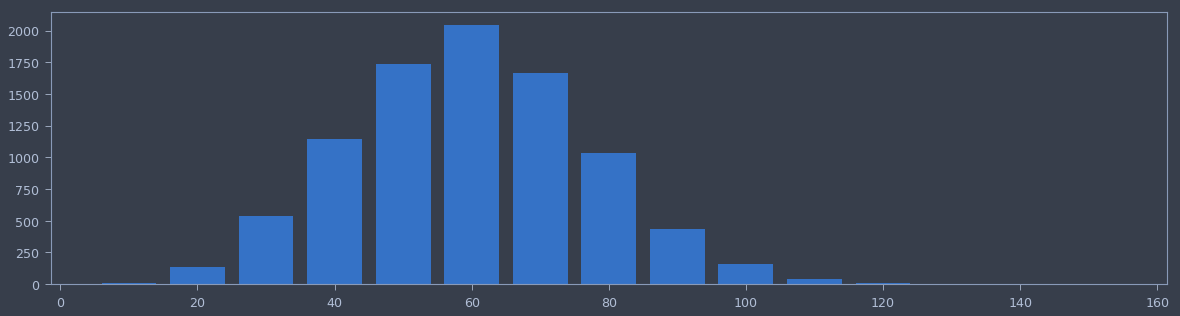

In [21]:
''' GT box widths vs Counts'''
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar(width_unique, width_counts, width=8);

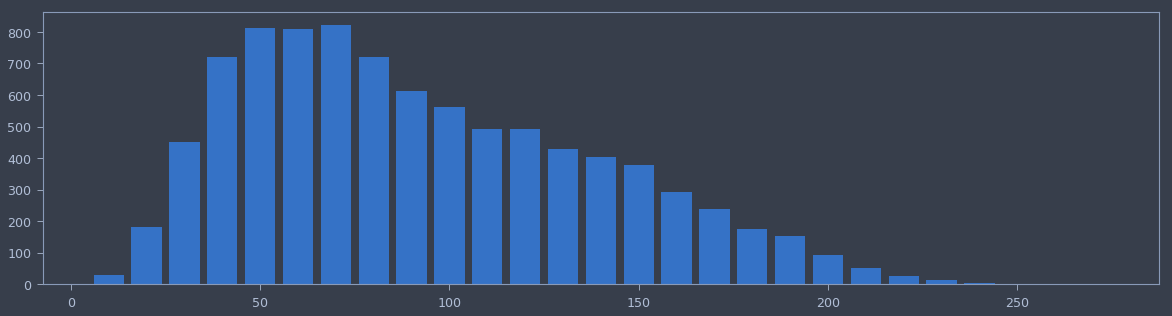

In [22]:
''' GT box heights vs Counts'''
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar(height_unique, height_counts, width=8);

#### Note: aspect ratio = w / h, we need priors with aspect ratios less than one.

100%|██████████| 8964/8964 [00:15<00:00, 580.88it/s]


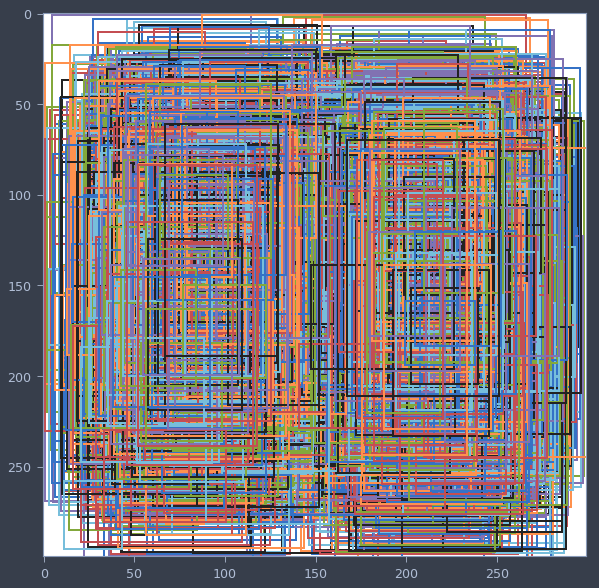

In [23]:
'''Let's plot all the bounding boxes on a canvas '''
canvas = np.ones([300, 300])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(figsize=(10, 10))
for box in tqdm(boxes):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), width=x2-x1, height=y2-y1, edgecolor=random.choice(colors), fill=None, linewidth=2)
    ax.add_patch(rect)
ax.imshow(canvas, cmap='binary')
plt.show();

100%|██████████| 8964/8964 [00:00<00:00, 289075.53it/s]


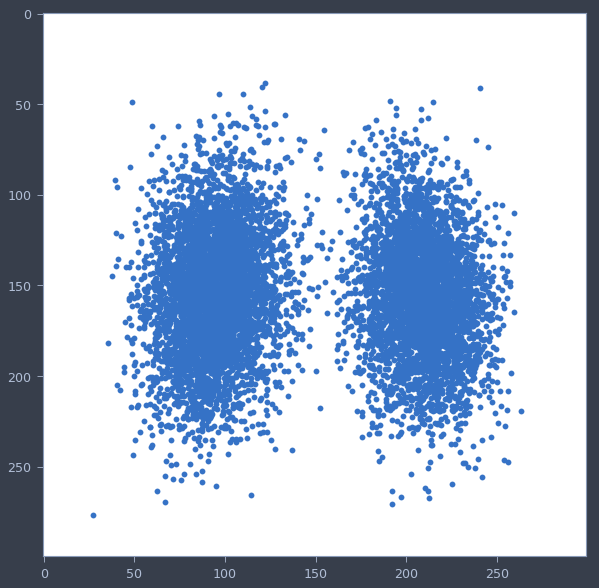

In [25]:
'''Ploting centroids as dots on a canvas'''
canvas = np.ones([300, 300])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(figsize=(10, 10))
xs, ys = [], []
for box in tqdm(boxes):
    x1, y1, x2, y2 = box
    x, y = (x1 + x2) /2, (y1 + y2) / 2
    xs.append(x)
    ys.append(y)
ax.imshow(canvas, cmap='binary')
ax.scatter(xs, ys)
plt.show();

In [ ]:
'''See variation in aspect ratios'''

In [100]:
ARs = set()
for box in boxes:
    x1, y1, x2, y2 = box
    ARs.add((x2-x1) / (y2-y1))

In [101]:
ARs

{0.3333333088620393,
 0.33333334067472176,
 0.33333336086354115,
 0.5,
 1.0,
 2.0,
 2.9999997522281503,
 2.999999933927506,
 3.0000002202416622}

#### NOTE: It can be seen, the ground truth bboxes have a fixed set of Aspect ratios: 1/3, 1/2, 1, 2, 3

## Analysing anchor boxes (priors) 

In [4]:
import sys
sys.path.append('..')
from functions import PriorBox
from config import cfg

HOME: /home/eee/ug/15084015/kaggle/rsna-pneumonia-detection-challenge


In [5]:
priors = PriorBox(cfg).forward() * 300

In [72]:
labels, boxes = [], []
widths, heights = [], []
for box in tqdm(priors):
    x, y, w, h = [i.item() for i in box]  # box is a torch tensor
    boxes.append([x, y, (x + w), (y + h)])
    widths.append(w)
    heights.append(h)
    
# these don't need to be multiplied by 300/ 1024, as these are already in 300 scale
boxes = np.array(boxes)
widths = np.array(widths)
heights = np.array(heights)

100%|██████████| 9695/9695 [00:00<00:00, 22277.70it/s]


In [73]:
min(widths), max(widths), min(heights), max(heights)

(34.64101791381836, 311.7691345214844, 34.64101791381836, 311.7691345214844)

In [74]:
dig_widths = digitize(widths)  # defined in 'Analyse Ground truth bbox section'
dig_heights = digitize(heights)
height_unique, height_counts = np.unique(dig_heights, return_counts=True)
width_unique, width_counts = np.unique(dig_widths, return_counts=True)

<IPython.core.display.Javascript object>


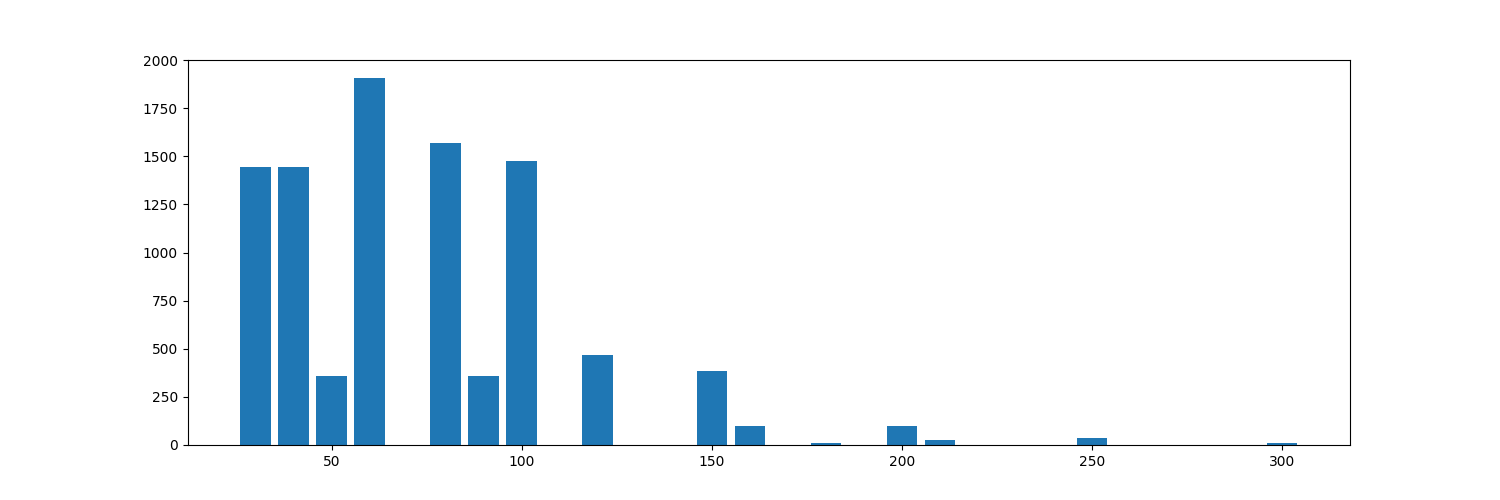

In [75]:
''' prior box widths vs Counts'''
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(width_unique, width_counts, width=8);

<IPython.core.display.Javascript object>


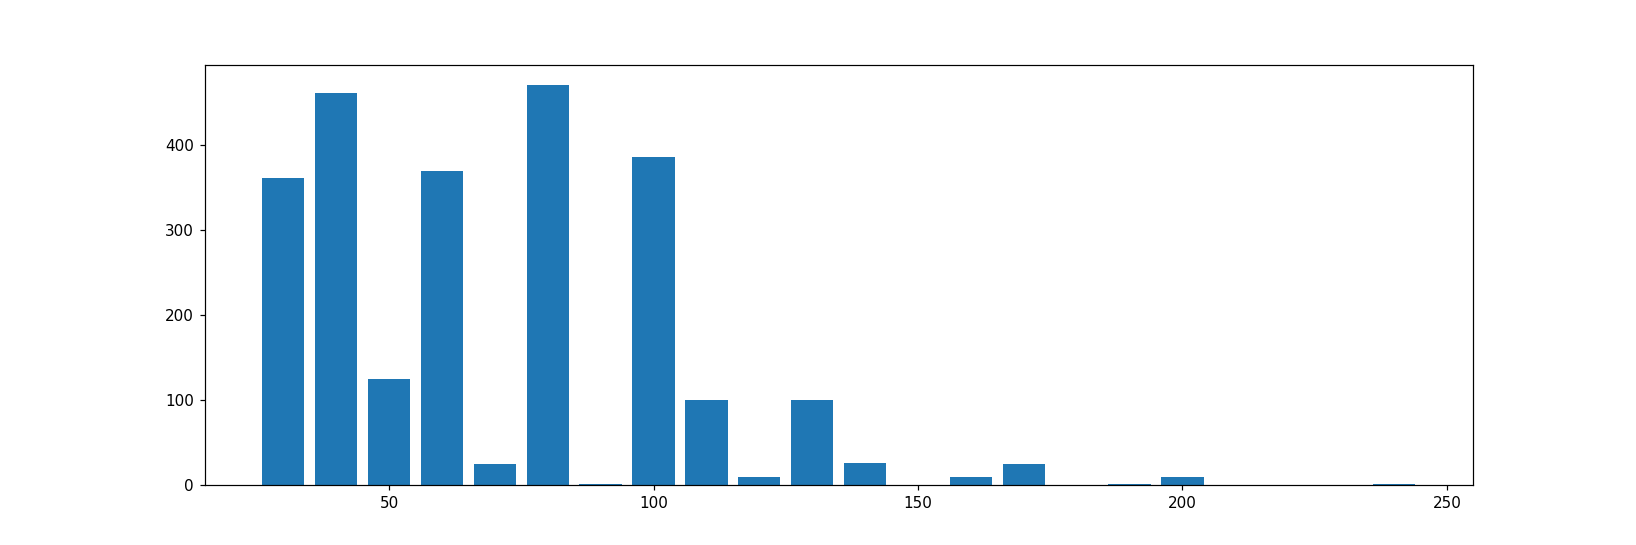

In [32]:
''' prior box heights vs Counts'''
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(height_unique, height_counts, width=8);

In [67]:
# [x for x in widths]
priors_ = priors

In [61]:
cfg = {
    'name': 'RSNA',
    'num_classes': 2,  # 1 is bg
    'lr_steps': (80000, 100000, 120000),
    'max_iter': 120000,
    'feature_maps': [38, 19, 10, 5, 3],
    'min_dim': 300,
    'steps': [8, 16, 32, 64, 100],  # distance b/w prior centroids (scaled to input image (300, 300))
    'min_sizes': [60, 90, 120, 150, 180],  # s_k's (scaled to input image) of each feature maps (essentially, w and h)
    'max_sizes': [80, 100, 120, 140, 160],
    'aspect_ratios': [[1/3, 1/2, 2, 3], [1/3, 1/2, 2, 3], [1/3, 1/2, 2, 3], [1/3, 1/2, 2, 3], [1/3, 1/2, 2, 3]],

    'variance': [0.1, 0.2],
    'clip': True,
    'base': {
        '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M', 512, 512, 512],
    },
    'extras': {
        '300': [256, 'S', 512, 128, 'S', 256, 128, 256, 128, 256],
    },
    'mbox': {
        '300': [5, 5, 5, 3, 3],  # number of boxes per feature map location
    }
}


In [3]:
def get_sk(k, m):
    '''to compute s_k, m: number of feature maps, k=[1, m] '''
    return 0.2 + (0.7 / (m - 1)) * (k - 1)

In [70]:
import pdb
from math import sqrt as sqrt
from itertools import product as product
import torch


class PriorBox(object):
    """Compute priorbox coordinates in center-offset form for each source
    feature map.
    """
    def __init__(self, cfg):
        super(PriorBox, self).__init__()
        self.image_size = cfg['min_dim']
        # number of priors for feature map location (either 4 or 6)
        self.num_priors = len(cfg['aspect_ratios'])
        self.variance = cfg['variance'] or [0.1]
        self.feature_maps = cfg['feature_maps']  # sizes of feature maps to be used
        self.min_sizes = cfg['min_sizes']
        self.max_sizes = cfg['max_sizes']
        self.steps = cfg['steps']
        self.aspect_ratios = cfg['aspect_ratios']
        self.clip = cfg['clip']
        self.version = cfg['name']
        for v in self.variance:
            if v <= 0:
                raise ValueError('Variances must be greater than 0')

    def forward(self):
        mean = []
        # pdb.set_trace()
        for k, f in enumerate(self.feature_maps):  # [19, 10, 5, 3, 1],
#             f_k = self.image_size / self.steps[k]  # [18.75, 9.375, 4.6875, 3.0, 1.0]
            f_k = self.steps[k]  # [16, 32, 64, 100, 300]
            for i, j in product(range(f), repeat=2):  # all possible coords in fxf feature map
                # f * f cells are there in each fm
                # 389, 100, 25, 3, 1 => prior boxes per fm
                # unit center x,y
#               cx = (j + 0.5) / f_k
#               cy = (i + 0.5) / f_k
                cx = (j + 0.5) * f_k
                cy = (i + 0.5) * f_k
                # print(f, cx, cy)
                # continue

                # aspect_ratio: 1
                # rel size: min_size
                s_k = self.min_sizes[k]
                mean += [cx, cy, s_k, s_k]
                # print([x*300 for x in mean[-4:]])
                # if s_k * 300 < 50:
                #     pdb.set_trace()

                # aspect_ratio: 1
                # rel size: sqrt(s_k * s_(k+1))
#                 s_k_prime = sqrt(s_k * (self.max_sizes[k]))
#                 mean += [cx, cy, s_k_prime, s_k_prime]
                # print(mean[-1])

                # rest of aspect ratios
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k * sqrt(ar), s_k / sqrt(ar)]  # transforming the box to the aspect ratio: ar, keeping the area constant (s_k ^ 2)
        # back to torch land
        output = torch.Tensor(mean).view(-1, 4)
#         if self.clip:
#             output.clamp_(max=1, min=0)
        return output

In [71]:
priors = PriorBox(cfg).forward()
priors.shape

torch.Size([9695, 4])

In [6]:
# for i in pd:
#     print(i)

100%|██████████| 2480/2480 [00:06<00:00, 403.06it/s]


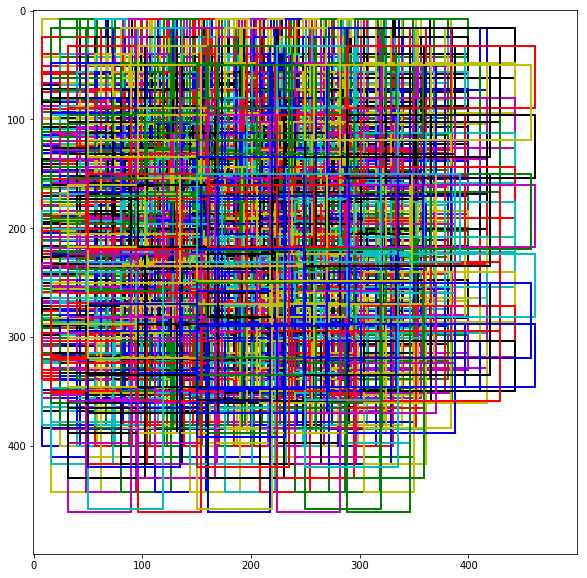

In [7]:
'''Let's plot all the priors (on a larger canvas that 300*300 as many priors go out of ROI)'''
canvas = np.ones([500, 500])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(figsize=(10, 10))
for box in tqdm(priors):
    x, y, w, h = box
    rect = plt.Rectangle((x, y), width=w, height=h, edgecolor=random.choice(colors), fill=None, linewidth=2)
    ax.add_patch(rect)
ax.imshow(canvas, cmap='binary')
plt.show();

100%|██████████| 1488/1488 [00:00<00:00, 26676.72it/s]


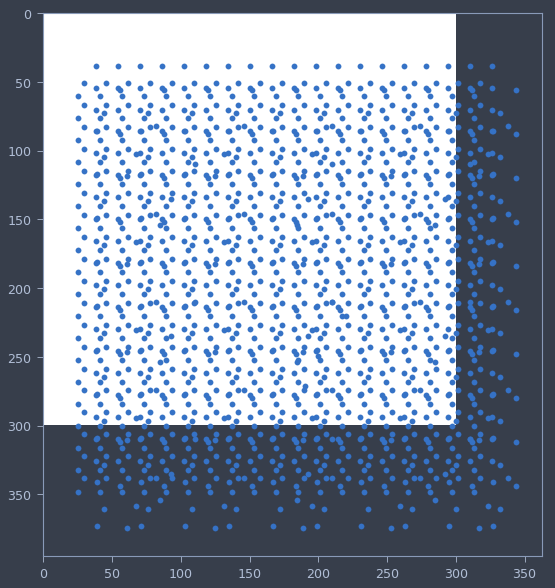

In [70]:
'''Ploting centroids as dots on a canvas'''
canvas = np.ones([300, 300])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(figsize=(10, 10))
xs, ys = [], []
for box in tqdm(priors):
    x1, y1, w, h = [i.item() for i in box]  # box is a torch tensor
    x, y = x1 + w /2, y1 + h / 2
    xs.append(x)
    ys.append(y)
ax.imshow(canvas, cmap='binary')
ax.scatter(xs, ys)
plt.show();

In [7]:
%matploblib notebook # has to be rerun for real time plotting (nonsense, i know)

<IPython.core.display.Javascript object>


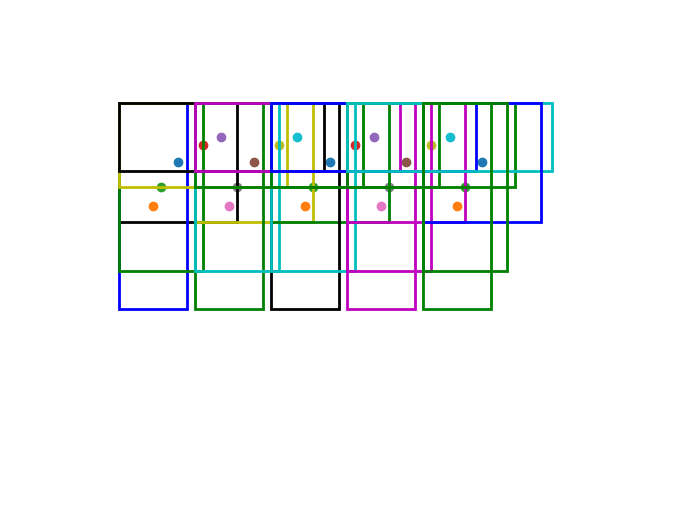

KeyboardInterrupt: 

In [38]:
canvas = np.ones([300, 300])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
count = 0
fig, ax = plt.subplots()#figsize=(10, 10))
ax.imshow(canvas, cmap='binary')
fig.canvas.draw()
start = 38**2*5 + 361*5 + 100*5
count = start
for idx, box in enumerate(priors[start:]):
    x, y, w, h = box
    if count>=0:
        rect = plt.Rectangle((x, y), width=w, height=h, edgecolor=random.choice(colors), fill=None, linewidth=2)
        ax.add_patch(rect)
        ax.scatter(x+w/2, y+h/2)
        fig.canvas.draw();
        plt.pause(1)
        ax.legend([count])
    count += 1
plt.show()

In [30]:
ARs = set()
for box in priors:
    x1, y1, w, h = box
    ARs.add((w/h).item())
ARs

{0.3333333134651184, 0.3333333432674408, 0.5, 1.0, 2.0, 2.999999761581421, 3.0}

In [ ]:
def area(box):
    XMin, YMin, XMax, YMax = box
    w = XMax - XMin + 1
    h = YMax - YMin + 1
#     print(abs(w), abs(h))
    return abs(w*h)

In [ ]:
for idx, box in enumerate(priors):
#     print(box)
    a = area(box)
    print(a)
#     break

In [ ]:
priors


## random testing

## Testing data

In [ ]:
df = pd.read_csv('data/stage_1_train_labels.csv')

In [ ]:
df.head()

In [ ]:
df = df[df['Target'] == 1]
df_groups = df.groupby(["patientId"]).groups

In [ ]:
df.head()

In [ ]:
df.iloc[0]

In [ ]:
random.seed(69)
df_groups = df.groupby(["patientId"]).groups
fnames = df_groups.keys()

In [ ]:

# train_fnames, val_fnames = train_test_split(fnames, test_size=0.2)
# fnames = train_fnames if phase == "train" else val_fnames
boxes = []
labels = []
for name in fnames:
    indices = df_groups[name]
    box, label = [], []
    for idx in indices:
        line = df.iloc[idx]
        if line['Target']:
            x, y = line["x"], line["y"]
            box.append([x, y, (x + line["width"]), (y + line["height"])])
    labels.append(np.zeros(len(box)))
    boxes.append(box)
    if len(boxes) >10: break  # just for testing
num_samples = len(fnames)


In [ ]:
len(fnames)

## Testing dataloader

In [ ]:
from data.dataloader import provider
# from utils.augmentations import *

In [ ]:
df = pd.read_csv("../data/stage_1_train_labels.csv")
df_groups = df.groupby(["patientId"]).groups

In [ ]:
dataloader = provider(phase='train', num_workers=4)

In [ ]:
# dataloader = provider(phase='train', num_workers=0)
# size=300
# mean=(104, 117, 123)
# transforms = [
#     ConvertFromInts(),
#     PhotometricDistort(),
#     Expand(mean),
# #     RandomSampleCrop(),
#     RandomMirror(),
#     ToPercentCoords(),
#     Resize(300),
#     SubtractMeans(mean)
# ]

# dataloader.dataset.transform.augment = Compose(transforms)

In [ ]:
fnames, images, boxes = next(iter(dataloader))
index_range = iter(range(len(images)))

In [ ]:
boxes

In [ ]:
# images[i].shape
# images[i].numpy().transpose(1,2,0) + np.array((104, 117, 123), dtype=np.float32)

In [ ]:
'''Plot random images from the dataloader with the original ground truth bboxes'''
# i = random.choice(list(range(len(images))))
i = next(index_range)
print(i, boxes[i])
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(111)
j = 0
for box in boxes[i]:
    box = [i.item() * 300 for i in box[:4]]
#     print(box)
    XMin, YMin, XMax, YMax = box
    w = XMax - XMin
    h = YMax - YMin
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)
    j += 1
img_aug = images[i].numpy().transpose(1,2,0) + np.array((104, 117, 123), dtype=np.float32)
img_aug = img_aug.astype('int')
ax.imshow(img_aug, cmap="gist_gray", label="aug image")


ax = fig.add_subplot(122)
# print(fnames[i])
gt_boxes = []
indices = df_groups[fnames[i]]
for idx in indices:
    line = df.iloc[idx]
    x, y = line["x"], line["y"]
    if line["Target"]:
        gt_boxes.append([x, y, (x + line["width"]), (y + line["height"])])
img = pydicom.read_file('../data/stage_1_train_images/' + fnames[i] + ".dcm")
img = np.expand_dims(img.pixel_array, -1)
img = img.repeat(3, axis=-1)
for box in gt_boxes:
    XMin, YMin, XMax, YMax = box
    w = XMax - XMin
    h = YMax - YMin
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)
    j += 1
ax.imshow(img / 255, cmap="gist_gray", label="org image")
plt.show()

In [ ]:
iaa.Affine?

In [ ]:
np.max(images[i].numpy().transpose(1,2,0))

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)


In [ ]:
ia.BoundingBoxesOnImage?

In [ ]:

image = ia.quokka(size=(256, 256))
bbs = ia.BoundingBoxesOnImage([ia.BoundingBox(*[0, 0, 1, 1])], shape=image.shape)

seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

seq_det = seq.to_deterministic()
image_aug = seq_det.augment_images([image])[0]
bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, thickness=2)
image_after = bbs_aug.draw_on_image(image_aug, thickness=2, color=[0, 0, 255])


In [ ]:
bbs_aug.

In [ ]:
plt.imshow(image_after)

## Prepare VOC formatted dataset

In [ ]:
from pascal_voc_writer import Writer
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
%matplotlib inline

In [ ]:
root = '/home/eee/ug/15084015/ML/codefest/data/'
image_data_root = '/home/eee/ug/15084015/ML/codefest/data/image_data/'

In [ ]:
'''Prepare xml annotations using bbox_train.csv file'''

image_root = 'VOCFace/JPEGImages/'
annotations_root = 'VOCFace/Annotations/'

df = pd.read_csv(root + "train.csv")
box_df = pd.read_csv(root + "bbox_train.csv")
fnames = df["Name"].values
box_df_groups = box_df.groupby(["Name"]).groups

for name in tqdm(fnames):
    indices = box_df_groups[name]
    width = box_df.iloc[indices[0]]['width']
    height = box_df.iloc[indices[0]]['height']
    writer = Writer(image_root + '17182.jpg', width, height)
    for idx in indices:
        line = box_df.iloc[idx]
        writer.addObject('face', line["xmin"], line["ymin"], line["xmax"], line["ymax"])
    writer.save(annotations_root + name.split('.')[0] + '.xml')

In [ ]:
'''Create trainval.txt file too '''
fnames_clean = [x.split('.')[0] for x in fnames]
trainvalfile = open('VOCFace/ImageSets/Main/trainval.txt', 'w')
for item in fnames_clean:
    trainvalfile.write("%s\n" % item)